In [21]:
import sys
import numpy as np
from astropy.io import fits
from os.path import basename
from copy import deepcopy as copy
import os
from astropy.wcs import WCS

from pyFIT3D.common.io import ReadArguments
from pyFIT3D.common.io import get_data_from_fits, array_to_fits
from pyFIT3D.common.constants import __FWHM_to_sigma__
from pyFIT3D.common.tools import flux_elines_cube_EW,momana_spec_wave

In [22]:
import numpy as np
from copy import deepcopy as copy
from os.path import basename, isfile
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
from astropy.io.fits.verify import VerifyWarning

from pyFIT3D.common.stats import median_filter as st_median_filter
from pyFIT3D.common.stats import hyperbolic_fit_par, std_m, pdl_stats, _STATS_POS
from pyFIT3D.common.io import trim_waves, get_data_from_fits, get_wave_from_header
from pyFIT3D.common.constants import __c__, __sigma_to_FWHM__, __indices__, _INDICES_POS
from pyFIT3D.common.io import output_spectra, array_to_fits, write_img_header, print_verbose
from pyFIT3D.common.constants import __Hubble_constant__, __Omega_matter__, __Omega_Lambda__
from pyFIT3D.common.constants import __solar_luminosity__, __solar_metallicity__, _figsize_default
from scipy.ndimage import gaussian_filter1d
#warnings.simplefilter('ignore', category=VerifyWarning)


In [23]:
from pyFIT3D.common.tools import vel_eline
from pyFIT3D.common.io import array_to_fits, get_data_from_fits, trim_waves

In [24]:
import yaml
from yaml.loader import SafeLoader

In [25]:
from astropy.table import Table
from astropy.table import vstack as vstack_table


In [6]:
import matplotlib.pyplot as plt

In [27]:
# platescale to convert fiber positions from mm to arcsec
PLATESCALE = 112.36748321030637

# directory where reduced cFrames are stored
#DIR_redux = '/data/LVM/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/'
DIR_redux = 'data/'
DIR_agcam = '/data/LVM/sdsswork/data/agcam/lco/'

In [28]:
def rotate(xx,yy,angle):
    # rotate x and y cartesian coordinates by angle (in degrees)
    # about the point (0,0)
    theta = -1.*angle * np.pi / 180. # in radians
    xx1 = np.cos(theta) * xx - np.sin(theta) * yy
    yy1 = np.sin(theta) * xx + np.cos(theta) * yy
    return xx1, yy1

def make_radec(xx0,yy0,ra,dec,pa):
    xx, yy = rotate(xx0,yy0,pa)
    ra_fib = ra + xx*PLATESCALE/3600./np.cos(dec*np.pi/180.) 
    dec_fib = dec - yy*PLATESCALE/3600. 
    return ra_fib, dec_fib

    
def make_line(wave, r1, sci, wl_shift_vel, whichone):

    # Halpha
    wl_ha = (wave > 6560 + wl_shift_vel/3e5*6560) & (wave < 6570+ wl_shift_vel/3e5*6570)
    iis_ha = np.where(wl_ha)[0]
    ha = np.sum(r1[:,iis_ha],axis=1)[sci]

    wl_ha_cont = (wave > 6600+ wl_shift_vel/3e5*6600) & (wave < 6610+ wl_shift_vel/3e5*6610)
    iis_ha_cont = np.where(wl_ha_cont)[0]
    ha_cont = np.sum(r1[:,iis_ha_cont],axis=1)[sci]
        
        
    # SII doublet

    wl_sii1 = (wave > 6715+ wl_shift_vel/3e5*6715) & (wave < 6725+ wl_shift_vel/3e5*6725)
    iis_sii1 = np.where(wl_sii1)[0]
    sii1 = np.sum(r1[:,iis_sii1],axis=1)[sci]

    wl_sii2 = (wave > 6730+ wl_shift_vel/3e5*6730) & (wave < 6740+ wl_shift_vel/3e5*6740)
    iis_sii2 = np.where(wl_sii2)[0]
    sii2 = np.sum(r1[:,iis_sii2],axis=1)[sci]


    wl_sii_cont = (wave > 6700+ wl_shift_vel/3e5*6700) & (wave < 6710+ wl_shift_vel/3e5*6710)
    iis_sii_cont = np.where(wl_sii_cont)[0]
    sii_cont = np.sum(r1[:,iis_sii_cont],axis=1)[sci]
        
        
    # [SIII]9069

    wl_siii9068 = (wave > 9065+ wl_shift_vel/3e5*9065) & (wave < 9075+ wl_shift_vel/3e5*9075)
    iis_siii9068 = np.where(wl_siii9068)[0]
    siii9068 = np.sum(r1[:,iis_siii9068],axis=1)[sci]
    
    # [OIII]5007
    wl_oiii = (wave > 5000 + wl_shift_vel/3e5*5000) & (wave < 5015+ wl_shift_vel/3e5*5015)
    iis_oiii = np.where(wl_oiii)[0]
    oiii = np.sum(r1[:,iis_oiii],axis=1)[sci]
    
    
    # [OIII]4363    
    wl_oiii4363 = (wave > 4360 + wl_shift_vel/3e5*4360) & (wave < 4365+ wl_shift_vel/3e5*4365)
    iis_oiii4363 = np.where(wl_oiii4363)[0]
    oiii4363 = np.sum(r1[:,iis_oiii4363],axis=1)[sci]

    wl_oiii4363_cont = (wave > 4375+ wl_shift_vel/3e5*4375) & (wave < 4380+ wl_shift_vel/3e5*4380)
    iis_oiii4363_cont = np.where(wl_oiii4363_cont)[0]
    oiii4363_cont = np.sum(r1[:,iis_oiii4363_cont],axis=1)[sci]
   
    # [OII]3727
    wl_oii = (wave > 3720 + wl_shift_vel/3e5*3720) & (wave < 3732+ wl_shift_vel/3e5*3732)
    iis_oii = np.where(wl_oii)[0]
    oii = np.sum(r1[:,iis_oii],axis=1)[sci]
    
    #[NII]5755
    wl_nii5755 = (wave > 5752 + wl_shift_vel/3e5*5752) & (wave < 5758+ wl_shift_vel/3e5*5758)
    iis_nii5755 = np.where(wl_nii5755)[0]
    nii5755 = np.sum(r1[:,iis_nii5755],axis=1)[sci]

    wl_nii5755_cont = (wave > 5710+ wl_shift_vel/3e5*5710) & (wave < 5715+ wl_shift_vel/3e5*5715)
    iis_nii5755_cont = np.where(wl_nii5755_cont)[0]
    nii5755_cont = np.sum(r1[:,iis_nii5755_cont],axis=1)[sci]
    
    wl_nii5755_cont2 = (wave > 5770+ wl_shift_vel/3e5*5770) & (wave < 5775+ wl_shift_vel/3e5*5775)
    iis_nii5755_cont2 = np.where(wl_nii5755_cont2)[0]
    nii5755_cont2 = np.sum(r1[:,iis_nii5755_cont2],axis=1)[sci]
   
    #r band
    wl_r = (wave > 5500 + wl_shift_vel/3e5*5500) & (wave < 6900+ wl_shift_vel/3e5*6900)
    iis_r = np.where(wl_r)[0]
    r = np.sum(r1[:,iis_r],axis=1)[sci]


    if whichone == 'ha':
        return ha
    if whichone == 'ha_sub':
        return ha - ha_cont
    if whichone == 'sii':
        return sii1 + sii2
    if whichone == 'sii_ratio':
        ratio = sii1/sii2
        ratio[sii1+sii2 < 10] = np.nan
        return ratio
    if whichone == 'siii':
        return siii9068
    
    if whichone == 'oiii': 
        return oiii
    
    if whichone == 'oii':
        return oii
    
    if whichone == 'oiii4363':
        return oiii4363 - oiii4363_cont
    
    if whichone == 'nii5755':
        return nii5755 - (nii5755_cont + nii5755_cont2)/2.
   
    if whichone == 'r_cont':
        return r

def read_file(file_ID, mjd, whichone = 'ha', wl_shift_vel = 0., nobad=False):
    pref = DIR_redux + (mjd) + '/'
    
    # read in the rss file
    rsshdu = fits.open(pref+'lvmCFrame-'+file_ID+'.fits')

    hdr = rsshdu[0].header

    r1 = rsshdu[1].data
    r1_hdr = rsshdu[1].header
    r1_err = rsshdu[2]

    wave=rsshdu[4].data 

    tab = Table(rsshdu[6].data)
    sci = (tab['targettype']=='science')
    if nobad:
        sci = (tab['targettype']=='science') & (tab['fibstatus'] == 0)

    rsshdu.close()

    # get ra/dec measured from coadd guiders?
    agcam_coadd = DIR_agcam+mjd+'/'+'lvm.sci.coadd_s'+file_ID+'.fits'
    if os.path.isfile(agcam_coadd):
        agcam_hdu = fits.open(agcam_coadd)
        agcam_hdr = agcam_hdu[1].header
        w = WCS(agcam_hdr)
        cen = w.pixel_to_world(2500,1000)
        racen = cen.ra.deg  #agcam_hdr['RAMEAS']
        deccen = cen.dec.deg #agcam_hdr['DECMEAS']
        pa = agcam_hdr['PAMEAS'] - 180.
        agcam_hdu.close()
    else:
        racen = hdr['POSCIRA']
        deccen = hdr['POSCIDE']
        pa = hdr['POSCIPA']


#    print(hdr['OBJECT'],hdr['POSCIPA'])
    #ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], hdr['POSCIRA'], hdr['POSCIDE'], hdr['POSCIPA'])
#    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], hdr['TESCIRA'], hdr['TESCIDE'], hdr['POSCIPA'])
    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], racen, deccen, pa)

    line_flux = make_line(wave, r1,sci, wl_shift_vel, whichone)

    return ra_fib.data, dec_fib.data, line_flux

def plotty(line_dict, vmin, vmax, title, filename, size=30):
#    size = 30

    fig = plt.figure(figsize=(8,8))
#    for dd in line_dict:
#        d = line_dict[dd]
#        print(dd,d)
    plt.scatter(line_dict['ra_fib'],line_dict['dec_fib'], c =line_dict['line'] ,s=size,vmin = vmin, vmax = vmax)

    plt.title(title)
    plt.xlabel('Ra [deg]')
    plt.ylabel('Dec [deg]')
    plt.colorbar()

    ax = plt.gca()

    xx = ax.get_xlim()
    plt.xlim(xx[1],xx[0])

    ax.set_aspect('equal', adjustable='box')
    plt.draw()
    plt.show()
    fig.savefig('figs/'+filename+'.png')

    plt.close()




In [39]:
def read_PT(fitsfile, agcam_coadd, nobad=False):
    rsshdu = fits.open(fitsfile)

    hdr = rsshdu[0].header
    tab = Table(rsshdu['SLITMAP'].data)
    sci = np.full(len(tab), True)
    #(tab['targettype']=='science')
    mask_bad = (tab['targettype']=='science') & (tab['fibstatus'] == 0) 
    if nobad:
        sci = (tab['targettype']=='science') & (tab['fibstatus'] == 0)
    rsshdu.close()

    # get ra/dec measured from coadd guiders?
    # agcam_coadd = DIR_agcam+mjd+'/'+'lvm.sci.coadd_s'+file_ID+'.fits'
    if os.path.isfile(agcam_coadd):
        agcam_hdu = fits.open(agcam_coadd)
        agcam_hdr = agcam_hdu[1].header
        w = WCS(agcam_hdr)
        cen = w.pixel_to_world(2500,1000)
        racen = cen.ra.deg  #agcam_hdr['RAMEAS']
        deccen = cen.dec.deg #agcam_hdr['DECMEAS']
        pa = agcam_hdr['PAMEAS'] - 180.
        agcam_hdu.close()
    else:
        racen = hdr['POSCIRA']
        deccen = hdr['POSCIDE']
        pa = hdr['POSCIPA']

    ra_fib, dec_fib = make_radec(tab['xpmm'][sci], tab['ypmm'][sci], racen, deccen, pa)
    tab=Table()
    tab['ra']=ra_fib.data
    tab['dec']=dec_fib.data
    tab['mask']=mask_bad
#    print(len(sci))
#    tab['mask']=sci
#    print(sci)
    return tab


In [40]:
def vel_map_RSS(RSS,wave,wmin,wmax,nsearch,imin,wave_ref):
    mask_wave = trim_waves(wave, [wmin, wmax])
    wave = wave[mask_wave]
    a_vel=[]
    a_npeaks=[]
    for flux in RSS:
        flux = flux[mask_wave]
        vel, _, npeaks = vel_eline(flux, wave, nsearch, imin, wave_ref)
        a_vel.append(vel)
        a_npeaks.append(npeaks)
    a_vel=np.array(a_vel)
    a_npeaks=np.array(a_npeaks)
    return a_vel,a_npeaks

In [41]:
def flux_elines_RSS_EW(flux__wyx, input_header, n_MC, elines_list, vel__yx, sigma__yx,
                        eflux__wyx=None, flux_ssp__wyx=None, w_range=60):
    nx, nw = flux__wyx.shape
    print(nx,nw)
    crpix = input_header['CRPIX1']
    crval = input_header['CRVAL1']
    cdelt = input_header['CDELT1']
    w_min=crval+cdelt*(0-crpix)
    w_max=crval+cdelt*(nw-crpix)
    flux__wyx[np.isnan(flux__wyx)] = 0
    if eflux__wyx is not None:
        median_data = np.nanmedian(eflux__wyx)
        np.clip(eflux__wyx, -5*median_data, 5*median_data, out=eflux__wyx)
        eflux__wyx[np.isnan(eflux__wyx)] = 5*median_data
    else:
        eflux__wyx = np.zeros_like(flux__wyx)
    if flux_ssp__wyx is not None:
        mean_data = np.nanmean(flux_ssp__wyx)
        flux_ssp__wyx[np.isnan(flux_ssp__wyx)] = mean_data
    if not isinstance(vel__yx, np.ndarray):
        vel__yx = vel__yx*np.ones([nx])    
    [nx1] = vel__yx.shape
    if not isinstance(sigma__yx, np.ndarray):
        sigma__yx = sigma__yx*np.ones(nx1)
    if nx1 < nx:
        nx = nx1
    wavelengths = np.array([])
    name_elines = np.array([])
    ne = 0
    with open(elines_list) as fp:
        line = fp.readline()
        while line:
            if not line.startswith('#'):
                tmp_line = line.strip().split()
                if len(tmp_line) > 1:
                    wave_now=float(tmp_line[0])
                    if ((wave_now>w_min)&(wave_now<w_max)):
                        wavelengths = np.append(wavelengths, float(tmp_line[0]))
                        name_elines = np.append(name_elines, tmp_line[1])
                        ne += 1
#                else:
#                    wavelengths = np.append(wavelengths, 0)
#                    name_elines = np.append(name_elines, ' ')
 
            line = fp.readline()
    NZ_out = ne * 4 * 2
    out = np.zeros([NZ_out, nx])
    print('{} emission lines'.format(ne))
    labels = ['flux', 'vel', 'disp', 'EW','e_flux', 'e_vel', 'e_disp', 'e_EW']
    for i, name in enumerate(name_elines):
        _tmp = [i, i + ne, i + 2*ne, i + 3*ne, i + 4*ne, i + 5*ne, i + 6*ne, i + 7*ne]
        for j, I in enumerate(_tmp):
            header_label = 'NAME{}'.format(I)
            wavelen_label = 'WAVE{}'.format(I)
            units_label = 'UNIT{}'.format(I)
            if ('vel'==labels[j]) | ('e_vel'==labels[j]):
                units = 'km/s'
            if ('disp'==labels[j]) | ('e_disp'==labels[j]):
                units = 'km/s'
            if ('flux'==labels[j]) | ('e_flux'==labels[j]):
                units = '10^-16 erg/s/cm^2'
            if ('EW'==labels[j]) | ('e_EW'==labels[j]):
                units = 'Angstrom'
            input_header[header_label] = '{} {}'.format(labels[j], name)
            input_header[wavelen_label] = '{}'.format(wavelengths[i])
            input_header[units_label] = "{}".format(units)
    for k in np.arange(0, ne):
        f_m = 1 + vel__yx / __c__
        start_w_m = wavelengths[k]*f_m - 1.5*__sigma_to_FWHM__*sigma__yx
        end_w_m = wavelengths[k]*f_m + 1.5*__sigma_to_FWHM__*sigma__yx
        start_i_m = ((start_w_m - crval)/cdelt).astype(int)
        end_i_m = ((end_w_m - crval)/cdelt).astype(int)
        d_w_m = (end_w_m - start_w_m)/4
        start_i_lim_m = ((start_w_m - crval - w_range)/cdelt).astype(int)
        end_i_lim_m = ((end_w_m - crval + w_range)/cdelt).astype(int)
        mask1 = (start_i_m < 0) | (end_i_m < 0)
        mask2 = (start_i_m >= nw - 1) | (end_i_m >= nw - 1)
        mask3 = (start_i_lim_m >= nw - 1) | (end_i_lim_m >= nw - 1)
        sigma_mask = sigma__yx > 0
        mask = (~(mask1 | mask2 | mask3)) & sigma_mask
        [i_m] = np.where(mask)
        
        for i in i_m:
            I0, vel_I1, I2, EW, s_I0, s_vel_I1, s_I2, e_EW = momana_spec_wave(
                gas_flux__w=flux__wyx[i, :],
                egas_flux__w=eflux__wyx[i, :],
                wave=wavelengths[k],
                vel=vel__yx[i],
                sigma=sigma__yx[i],
                crval=crval, cdelt=cdelt,
                n_MC=n_MC, flux_ssp__w=flux_ssp__wyx[i, :],
            )
            #print(f'vel {vel_I1} vs {vel__yx[i]}')

            out[k, i] = I0
            out[ne + k, i] = vel_I1
            out[2*ne + k, i] = I2
            out[3*ne + k, i] = EW
            out[4*ne + k, i] = s_I0
            out[5*ne + k, i] = s_vel_I1
            out[6*ne + k, i] = s_I2
            out[7*ne + k, i] = e_EW
        print('{}/{}, {},{} DONE'.format(k + 1, ne, wavelengths[k], name_elines[k]))
    return out, input_header



In [64]:
#elines_list="/disk-b/sanchez/ppak/legacy/emission_lines_long_list.MaNGA"
#elines_list="/disk-a/sanchez/ppak/legacy/emission_lines_long_list.MaNGA"
elines_list="/disk-a/sanchez/ppak/legacy/emission_lines_STRONG.lines"

IDs=('09','10','11','12','13','14','15')
for ID in IDs:
    hdu_org=fits.open(f'data/lvmCFrame-000061{ID}.fits')
    print(hdu.info())
    outfile=f'output/lvmSCFrame-000061{ID}.fe.fits'
    hdu=fits.open(f'data/lvmSCFrame-000061{ID}.fits')
    print(hdu.info())
    (ny,nx)=hdu[0].data.shape
    print(nx,ny)
    vel__yx=np.zeros(ny)
    sigma__yx=1.5

    out, input_cube_header=flux_elines_RSS_EW(hdu[0].data, hdu[0].header, 5, elines_list, vel__yx,\
                                              sigma__yx,eflux__wyx=hdu_org[2].data,\
                                              flux_ssp__wyx=hdu_org[1].data,w_range=15)
    array_to_fits(outfile, out, header=input_cube_header, overwrite=True, sort_dict_header=False)
    print(f'ID {ID} DONE')

Filename: data/lvmSCFrame-00006109.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  FLUX          1 PrimaryHDU     334   (12401, 1944)   float64   
None
Filename: data/lvmSCFrame-00006109.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  FLUX          1 PrimaryHDU      23   (12401, 1944)   float64   
None
12401 1944
1944 12401
13 emission lines


/home/sanchez/.local/lib/python3.8/site-packages/pyFIT3D/common/tools.py:1432: RuntimeWarning: invalid value encountered in double_scalars
  s_I2 = np.sqrt(s_I2**2 + (e_val_cont/I2) **2 + (0.1*I2)**2)


1/13, 3727.0,[OII] DONE
2/13, 4101.0,Hd DONE
3/13, 4340.468,Hg DONE
4/13, 4861.32,Hb DONE
5/13, 4959.0,[OIII]4959 DONE
6/13, 5007.0,[OIII]5007 DONE
7/13, 6562.817,Ha DONE
8/13, 6583.6,[NII]6584 DONE
9/13, 6548.1,[NII]6548 DONE
10/13, 6716.47,[SII]6717 DONE
11/13, 6730.85,[SII]6731 DONE
12/13, 9531.1,[SIII] DONE
13/13, 9682.13,[FeII] DONE
ID 09 DONE
Filename: data/lvmSCFrame-00006109.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  FLUX          1 PrimaryHDU     336   (12401, 1944)   float64   
None
Filename: data/lvmSCFrame-00006110.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  FLUX          1 PrimaryHDU      23   (12401, 1944)   float64   
None
12401 1944
1944 12401
13 emission lines
1/13, 3727.0,[OII] DONE
2/13, 4101.0,Hd DONE
3/13, 4340.468,Hg DONE
4/13, 4861.32,Hb DONE
5/13, 4959.0,[OIII]4959 DONE
6/13, 5007.0,[OIII]5007 DONE
7/13, 6562.817,Ha DONE
8/13, 6583.6,[NII]6584 DONE
9/13, 6548.1,[NII]6548 DONE
10/13, 6716.47,[SII]6717 DONE


In [43]:
tab_PT = read_PT('data/lvmCFrame-00006109.fits','none')
tab_PT

ra,dec,mask
float64,float64,bool
97.600321,4.921521,False
97.64508970403955,4.761865534272023,False
97.600321,4.674312536937326,True
97.60928100654675,4.679462713251132,True
97.61824101309351,4.684612889564938,True
97.62716969094603,4.6897630658787435,True
97.63612969749279,4.694913242192549,True
97.64508970403955,4.700063418506355,True
97.6540497105863,4.705213594820161,True


flux_[OII]
1186.2481715219744 253.76143007441607 8753.746537978368


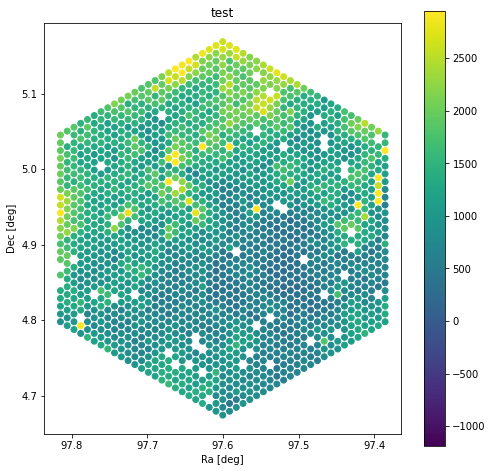

In [63]:
nl=0
name=input_cube_header[f'NAME{nl}']
name=name.replace(' ','_')
print(name)
tab_line = Table()
tab_line['ra_fib']=tab_PT['ra'][tab_PT['mask']]
tab_line['dec_fib']=tab_PT['dec'][tab_PT['mask']]
tab_line['line']=out[nl,:][tab_PT['mask']]
print(np.nanmean(tab_line['line']),np.min(tab_line['line']),np.nanmax(tab_line['line']))
plotty(tab_line, -np.nanmean(tab_line['line']), 5*np.nanstd(tab_line['line']), 'test', 'test', size=35)